In [1]:
import torch
from torch import nn
from IPython.display import clear_output

from src.encoder import Encoder, GPT2Encoder
from src.decoder import Decoder, GPT2Decoder
from src.graph_initialization import random_unidirectional_graph_maker, linear_bidirectional_graph_maker
from src.graphAN import GraphAttentionNetwork, BlockGenerator
from src.data_loader import validation
from src.tokenizer import Tokenizer
from src.GPT2 import GPT2_Block, GPT2
from matplotlib import pyplot as plt
from src.utils import moving_average, grad_norm
from torch.nn.utils import clip_grad_norm_
import pickle
import numpy as np
from termcolor import colored
from torch.nn import functional as F
import einops

import torch

from src.cellular_automata import CellularAutomata
from src.tokenizer import CharTokenizer

from src.cellular_automata import DiffusionLoss
from src.decoder import Loss
from src.encoder import NoiseEncoder
from src.training_pool import SamplePool, TextGenerator

In [2]:
dir_path = 'shakespeare_data/'
input_file_path = dir_path+'input.txt'


#create the tokenizer
tokenizer = CharTokenizer(input_file_path)
print('tokenizer vocab size:', tokenizer.vocab_size)

# load the data

device = 'cpu'
#device = 'mps'  if torch.backends.mps.is_available() else 'cpu'
device = 'cuda' if torch.cuda.is_available() else device

dK = 16
dV = 16
heads = 4
d_Embedding = 65
intermediate_size=2*d_Embedding

encoder = NoiseEncoder(d_Embedding, tokenizer, dropout=0, device=device, one_hot=True)
decoder = Decoder(encoder)
block_generator = BlockGenerator(GPT2_Block, d_Embedding, dK, dV, heads, intermediate_size,
                                 dropout=0.1, split_size=2**10, device=device, rotary_encoding=True)

model = CellularAutomata(tokenizer, encoder, block_generator, decoder, n_blocks=2)
model.logs={'loss':[],'step_loss':[], 'loss_components':[[],[],[]]}
model.tokens_seen=0

graph_maker = linear_bidirectional_graph_maker(64, device=device)

print(f'number of parameters:{model.n_parameters}')

lr = 2e-2
gamma = 0.99

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma)
step_weight=None


loss_function=DiffusionLoss(decoder,1e-2,1e-1)

sequence_lenght=100
text_generator=TextGenerator(input_file_path, lenght=sequence_lenght, encoder=encoder)
pool=SamplePool(pool_size=1000, generator=text_generator, encoder=encoder, indexes_max_loss_size=5)


#@title {vertical-output: true}
#@markdown # Training
#@markdown the loss function is cross entropy ❌🎲

edge_index = graph_maker(sequence_lenght)

length of dataset in characters: 1,115,394
tokenizer vocab size: 65
number of parameters:75530


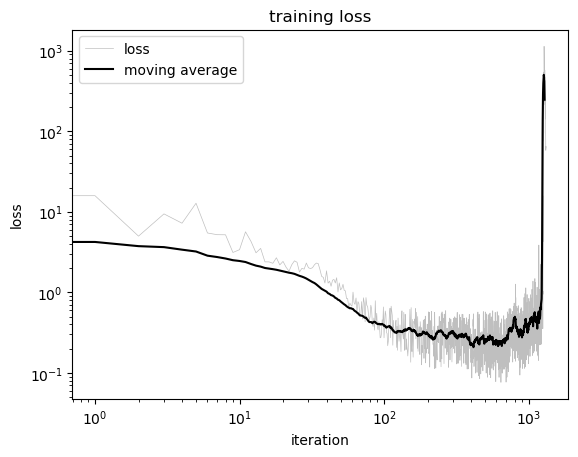

In [3]:
#@title {vertical-output: true}
#@markdown # Training
#@markdown the loss function is cross entropy ❌🎲

n_epochs = int(2000)
model.train()
n_steps=10

for i in range(n_epochs):
    idx = np.random.randint(pool.size)
    target_tokens, prediction, clean_embeddings, noise_encoding, noise_level = pool[idx]

    step_loss = torch.empty(n_steps+1, device=device)
    loss_components = torch.empty([n_steps+1, 3], device=device)

    #do n steps
    step_loss[0], loss_components[0] = loss_function(prediction, target_tokens, clean_embeddings, noise_encoding)
    for j in range(1, n_steps+1):
        #make a forward pass
        prediction = model(prediction, edge_index)

        #compute loss
        step_loss[j], loss_components[j] = loss_function(prediction, target_tokens, clean_embeddings, noise_encoding)

        #apply step weight if given
        if step_weight is not None:
            step_loss[j] *= step_weight(j)

    #compute the total loss

    loss = step_loss.mean()

    model.logs['loss'].append(loss.item())
    model.logs['step_loss'].append(step_loss.detach().cpu().numpy())
    for log, l in zip(model.logs['loss_components'], loss_components.mean(dim=0)):
        log.append(l.item())

    loss.backward()
    clip_grad_norm_(model.parameters(), loss.item())

    optimizer.step()
    optimizer.zero_grad()  # reinitialize the gradient to zero
    model.tokens_seen += sequence_lenght

    if i>=200:
        pool.update(idx, prediction, n_steps, loss)

    logging_interval = 30
    if i % logging_interval == logging_interval-1:
        if i>=200:
            pool.clean_worst_performers()
        clear_output(wait=True)

        m_av = moving_average(model.logs['loss'], logging_interval-1)

        if m_av[-1]>5: pool.reset()
        plt.plot(model.logs['loss'], label='loss',
                 color='grey', alpha=0.5, linewidth=0.5)
        plt.plot(m_av, label='moving average', color='black')

        plt.title("training loss")
        plt.legend()
        plt.ylabel('loss')
        plt.xlabel('iteration')
        plt.yscale('log')
        plt.xscale('log')
        plt.show()

    



In [ ]:
noise=torch.tensor(0.6)
targ=text_generator()
print(f'original text:\n{tokenizer.decode(targ)}\n---------------------\n')
pred, clean, nois = encoder(targ, noise)

print(f'noised text:\n{tokenizer.decode(model.decoder(pred).argmax(dim=-1))}')

base_loss,_ = loss_function(pred, targ, clean, nois)
print(f'loss befor denoising= {base_loss.item()}\n---------------------\n')

l=[base_loss.item()]
for _ in range(8):
    pred = model(pred, edge_index)
    l.append(loss_function(pred, targ, clean, nois)[0].item())

print(f'denoised text:\n{tokenizer.decode(model.decoder(pred).argmax(dim=-1))}\n---------------------\n')
base_loss,_ = loss_function(pred, targ, clean, nois)
print(base_loss.item())


original text:
ifest where she has lived,
Or how stolen from the dead.

PAULINA:
That she is living,
Were it but to
---------------------

noised text:
&$$&&&&&&3&3&&3&&$&&333&&&&&&&&3&33&&&&3$3&$$$&$$33$&$3&&$3&$$$&3$$&&$&3&&&&3$&&3&$&&&&&$&3&&3&$33&$
loss befor denoising= 0.6439089775085449
---------------------

denoised text:
$$$$&&&$$$$$$&$$$$&$$$$$$$$$$$$$$$$$&$$$$$$$$$$$$&$$$$$$$$$$$$$$&$$$$$&$$$&$$$$&$&$$$&$&$$&$$&$$$$$$
---------------------

1.0944372415542603


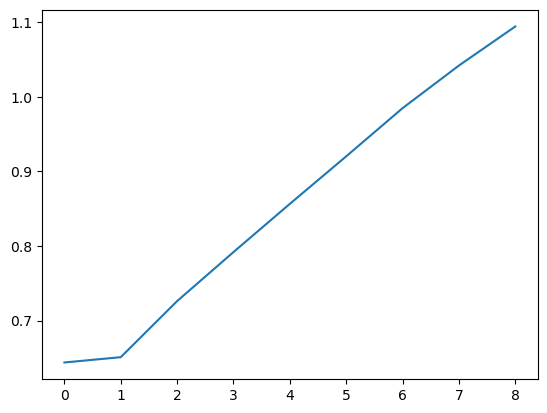

In [ ]:
plt.plot(l)

In [ ]:
print(10_000)

10000


In [ ]:
import matplotlib as mpl
encoding_prediction=[ log['loss']/(log['noise']+1e-8) for log in model.logs[-100:]]
colormap=plt.cm.get_cmap('viridis')

logs=model.logs
losses=[log['loss'] for log in logs]
noises=[log['noise'] for log in logs]
colors=colormap(np.logspace(-2.4,0,len(logs)))
plt.scatter(noises, losses, color=colors)


norm = mpl.colors.LogNorm(vmin=1, vmax=len(losses))
cmap=plt.cm.get_cmap('viridis_r')
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),label='iterations',ticks=[])
plt.yscale('log')
plt.ylabel('loss')
plt.xlabel('noise')

KeyError: 'noise'

In [ ]:
from src.diffusion_utils import denoise,reverse_DDIM,cosine_schedule

encoding_prediction=torch.randn(200,model.d_Embedding)
edge_index=graph_maker(encoding_prediction.shape[0])

out=denoise(model, reverse_DDIM, encoding_prediction, 100,10, cosine_schedule,edge_index=edge_index)
tokenizer.decode(model.decoder(out).argmax(dim=-1).detach().cpu().numpy())

'ssssZi R$s-ssTWttoo s\n$rPMtIsost-ss\nWrWW$tro-ITXottrMx otoos-forxTsUswtUf Ur xUFU   t&tUoW&\n tUftU-sarItoowoUtl&t oI&ss-UI&E WnsUPz$t\ntn- IzIrt o;UUOo ottrt$ooosfss C IOWt& tUW X-w sMt StstttoIo TUWoI'

In [ ]:
tok=tokenizer(text)
out=model(tok, graph_maker(len(tok)))

loss_function(out[:-1], tok[1:])

out=model.calculate_final_embedding(out, graph_maker(len(tok)))
out.shape

torch.Size([180, 50257])

In [ ]:
import numpy as np

def scaling(N,D):
    return 406.4/N**.34 + 410.7/D**.28 + 1.69


noised_encoding=np.logspace(0,3,100,base=10)
gpt2_estimate=scaling(124e6,9e9)

In [ ]:
scaling(30e9,9e20)

1.8019184514787685

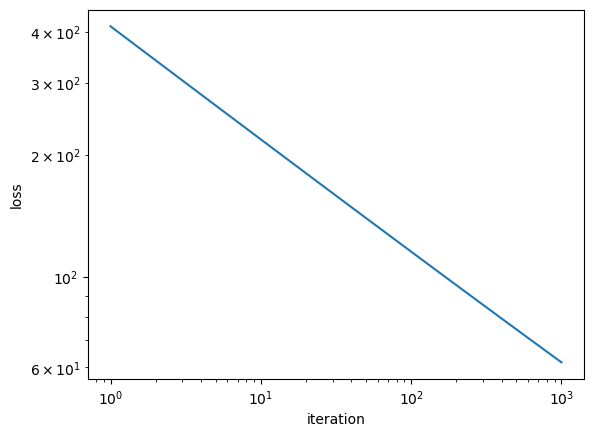

In [ ]:
from matplotlib import pyplot as plt

plt.plot(noised_encoding,y)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.yscale('log')
plt.xscale('log')
plt.show()